In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import os
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from tqdm import tqdm

/tmp/ipykernel_1049984/2250834380.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
model = '/volatile/jl277509/Runs/02_STS_babies/Program/Output/PCS_FINAL_MODEL/19-12-25_3/'

embeddings_CCD = pd.read_csv(os.path.join(model, "CCD_random_embeddings/full_embeddings.csv"), index_col=0)
embeddings_UKB = pd.read_csv(os.path.join(model, "UKB_random_embeddings/full_embeddings.csv"), index_col=0)
embeddings_UKB.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
sub-1000021,15.592494,34.494900,8.719974,84.042755,-2.338658,17.109613,17.615273,-1.569066,-0.724397,-3.401615,...,21.493185,-21.094856,-16.412336,0.503177,15.058713,-6.507754,-56.560260,-0.500706,22.970040,-0.897924
sub-1000458,21.859705,41.393238,16.137548,58.983418,14.475472,34.597996,-0.670761,-17.257439,2.672007,-8.064828,...,33.590267,-7.286129,-16.044346,-6.735470,13.279847,23.086065,-18.885305,15.098557,15.267213,-12.603914
sub-1000575,66.839590,-7.664413,16.941942,52.955128,-38.902386,-7.481332,-6.376166,2.011489,2.837864,8.470457,...,-26.563917,4.246506,-2.606314,-13.200418,0.386144,-7.431461,7.049025,20.465460,15.058507,21.503077
sub-1000606,41.851505,10.870255,31.636250,55.456170,13.537527,4.086966,33.851727,-4.856818,-23.671595,-4.551562,...,-15.102870,-13.294502,-0.053844,6.308680,26.031740,-13.061463,-39.270817,3.099191,3.324039,5.225338
sub-1000963,16.002398,13.636017,15.947115,71.199370,1.879433,28.217922,1.475944,6.490414,7.099989,1.988958,...,7.824328,-4.322985,-28.375147,31.262850,11.012692,-0.501506,-29.956993,21.468794,20.046604,-0.328055


In [3]:
CCD_labels = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/CCD/ccd_labels.csv')
CCD_labels = CCD_labels.set_index('Subject')
CCD_labels.index.name='ID'

In [4]:
emb = embeddings_CCD.merge(CCD_labels, left_index=True, right_index=True)
embeddings_CCD_controls = (emb.loc[emb['CCD']==0]).drop('CCD', axis=1)
embeddings_CCD_anomaly = (emb.loc[emb['CCD']==1]).drop('CCD', axis=1)

In [5]:
scaler = StandardScaler()
scaler.fit(embeddings_UKB)

scl_bdd_ccd_control = scaler.transform(embeddings_CCD_controls)
scl_bdd_ccd_anomaly = scaler.transform(embeddings_CCD_anomaly)
scl_bdd_ukb = scaler.transform(embeddings_UKB)

In [6]:
reducer2D = umap.UMAP(n_components=2)

reducer2D.fit(scl_bdd_ukb)

bdd_2D_CCD_control = reducer2D.transform(scl_bdd_ccd_control)
bdd_2D_CCD_anomaly = reducer2D.transform(scl_bdd_ccd_anomaly)
bdd_2D_UKB = reducer2D.transform(scl_bdd_ukb)

/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


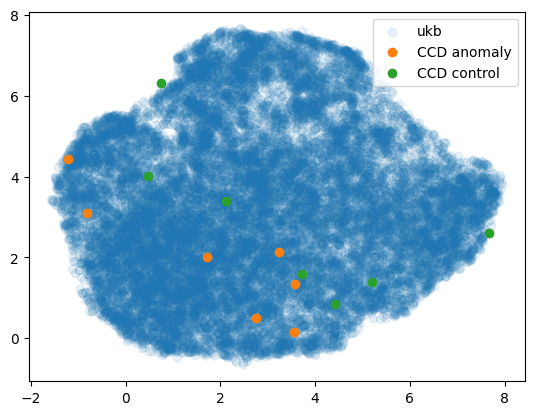

In [7]:
fig, ax = plt.subplots()
ax.scatter(bdd_2D_UKB[:, 0], bdd_2D_UKB[:, 1], alpha=0.1, label='ukb')
ax.scatter(bdd_2D_CCD_anomaly[:, 0], bdd_2D_CCD_anomaly[:, 1], alpha=1, label='CCD anomaly')
ax.scatter(bdd_2D_CCD_control[:, 0], bdd_2D_CCD_control[:, 1], alpha=1, label='CCD control')
plt.legend()
plt.show()

# distance in UMAP

In [8]:
all_subs_bdd = np.vstack((bdd_2D_UKB, bdd_2D_CCD_control, bdd_2D_CCD_anomaly))

In [9]:
for metric in 'euclidean', 'cosine':
    print(metric)
    ukb_dist = pairwise_distances(all_subs_bdd, metric=metric)
    avges = []
    for i in range(100):
        av = np.mean(ukb_dist[:, np.random.randint(0, 21045, 7)])
        avges.append(av)
    print(f'Average pairwise distance in ukb {np.mean(avges), np.std(avges)}')
    print(f'Average pairwise distance between CCD controls and ukb: {np.mean(ukb_dist[:, 21045:21052])}')
    print(f'Average pairwise distance between CCD anomalies and ukb: {np.mean(ukb_dist[:, 21052:21059])}')

euclidean


Average pairwise distance in ukb (np.float32(3.708531), np.float32(0.24458377))
Average pairwise distance between CCD controls and ukb: 3.8251147270202637
Average pairwise distance between CCD anomalies and ukb: 3.6779863834381104
cosine
Average pairwise distance in ukb (np.float32(0.23230095), np.float32(0.044090934))
Average pairwise distance between CCD controls and ukb: 0.2513822019100189
Average pairwise distance between CCD anomalies and ukb: 0.32374686002731323


CCD subjects are far from UKB using cosine metric ?

In [10]:
pairwise_dists = pairwise_distances(all_subs_bdd, metric='cosine')

In [12]:
sorted_dists = np.sort(pairwise_dists)

In [13]:
# on peut couper au k-ième plus proche voisin et regarder la distribution de distance
k = 50
distance_to_kth_neighbour = sorted_dists[:, k]
avges = []
for i in range(10000):
    av = np.mean(distance_to_kth_neighbour[np.random.randint(0, 21045, 7)])
    avges.append(av)
print(f'Average distance to {k}th neighboor in ukb {np.mean(avges):.5f}, {np.std(avges):.5f}')
print(f'Average distance to {k}th neighboor in CCD controls: {np.mean(distance_to_kth_neighbour[21045:21052]):.5f}')
print(f'Average distance to {k}th neighboor in CCD anomaly: {np.mean(distance_to_kth_neighbour[21052:21059]):.5f}')

Average distance to 50th neighboor in ukb 0.00006, 0.00092
Average distance to 50th neighboor in CCD controls: 0.00000
Average distance to 50th neighboor in CCD anomaly: 0.00001


# distances in latent space

In [7]:
all_subs_embs = pd.concat((embeddings_UKB, embeddings_CCD_controls, embeddings_CCD_anomaly), ignore_index=False)

In [31]:
for metric in 'euclidean', 'cosine':
    print(metric)
    ukb_dist = pairwise_distances(all_subs_embs, metric=metric)
    avges = []
    for i in range(100):
        av = np.mean(ukb_dist[:, np.random.randint(0, 21045, 7)])
        avges.append(av)
    print(f'Average pairwise distance in ukb {np.mean(avges), np.std(avges)}')
    print(f'Average pairwise distance between CCD controls and ukb: {np.mean(ukb_dist[:, 21045:21052])}')
    print(f'Average pairwise distance between CCD anomalies and ukb: {np.mean(ukb_dist[:, 21052:21059])}')

euclidean
Average pairwise distance in ukb (np.float64(306.5018047655891), np.float64(4.504720997379853))
Average pairwise distance between CCD controls and ukb: 301.05742528298305
Average pairwise distance between CCD anomalies and ukb: 296.52926831154326
cosine
Average pairwise distance in ukb (np.float64(0.6543959445598246), np.float64(0.00857310560423392))
Average pairwise distance between CCD controls and ukb: 0.6299564705698738
Average pairwise distance between CCD anomalies and ukb: 0.6321128630677075


# Use cosine distance only

In [133]:
#distance = 'cosine'
distance = 'chebyshev'
pairwise_dists = pairwise_distances(all_subs_embs, metric=distance)

In [135]:
sorted_dists = np.sort(pairwise_dists, axis=-1)
df_sorted_dists = pd.DataFrame(data=sorted_dists, index=all_subs_embs.index, columns = [k for k in range(len(sorted_dists))])

In [136]:
# on peut couper au k-ième plus proche voisin et regarder la distribution de distance
# un peu bizarre de faire une moyenne sur 7
k = 1
distance_to_kth_neighbour = df_sorted_dists[k]
avges = []
for i in range(10000):
    av = np.mean(distance_to_kth_neighbour[np.random.randint(0, 21045, 7)])
    avges.append(av)
print(f'Average distance to {k}th neighboor in ukb {np.mean(avges):.5f}, std: {np.std(avges):.5f}, 99th percentile: {np.percentile(avges, 99)}, 99.9th percentile: {np.percentile(avges, 99.9)}, 99.99th percentile: {np.percentile(avges, 99.99)}')
print(f'Average distance to {k}th neighboor in CCD controls: {np.mean(distance_to_kth_neighbour[21045:21052]):.5f}, std: {np.std(distance_to_kth_neighbour[21045:21052]):.5f}')
print(f'Average distance to {k}th neighboor in CCD anomaly: {np.mean(distance_to_kth_neighbour[21052:21059]):.5f}, std: {np.std(distance_to_kth_neighbour[21052:21059]):.5f}')

Average distance to 1th neighboor in ukb 18.22710, std: 0.93316, 99th percentile: 20.38943357957143, 99.9th percentile: 21.04920026010429, 99.99th percentile: 21.81146088211131
Average distance to 1th neighboor in CCD controls: 18.91166, std: 1.63547
Average distance to 1th neighboor in CCD anomaly: 20.48536, std: 2.82331


/tmp/ipykernel_1791048/28450133.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  av = np.mean(distance_to_kth_neighbour[np.random.randint(0, 21045, 7)])


In [137]:
# ne plus faire des moyennes sur 7 sujets
k = 1
distance_to_kth_neighbour = df_sorted_dists[k]
print(f'Individual distance in CCD anomaly: {distance_to_kth_neighbour[21052:21059]}')
print(f'Individual distance in CCD controls: {distance_to_kth_neighbour[21045:21052]}')

Individual distance in CCD anomaly: ID
ca090293    18.155037
cr070055    15.899771
gd070065    21.005067
lc110410    19.825178
np090301    24.747794
pa080037    23.693707
pz080261    20.070940
Name: 1, dtype: float64
Individual distance in CCD controls: ID
ag080048    20.145882
bt080019    16.431198
cd100556    18.291264
fb070174    20.445674
md110095    16.814046
mm080047    19.435333
vp100400    20.818217
Name: 1, dtype: float64


In [138]:
print(distance_to_kth_neighbour[21052:21059].index)
print(distance_to_kth_neighbour[21045:21052].index)

Index(['ca090293', 'cr070055', 'gd070065', 'lc110410', 'np090301', 'pa080037',
       'pz080261'],
      dtype='object', name='ID')
Index(['ag080048', 'bt080019', 'cd100556', 'fb070174', 'md110095', 'mm080047',
       'vp100400'],
      dtype='object', name='ID')


In [139]:
np.stack([distance_to_kth_neighbour[21052:21059] for i in range(1000)]).flatten().shape

(7000,)

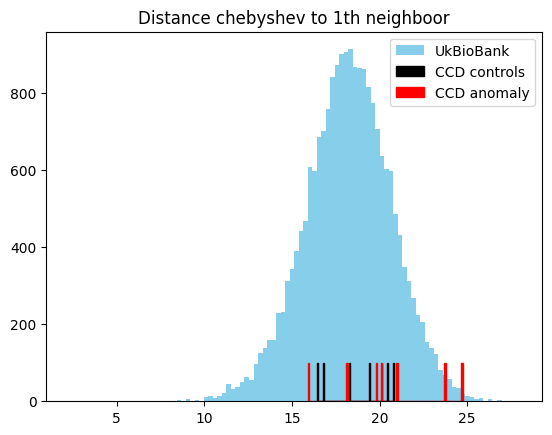

In [140]:
fig, ax = plt.subplots()
bins=100
ax.hist(distance_to_kth_neighbour[:21045], label='UkBioBank', color='skyblue', bins=bins)
ax.hist(np.stack([distance_to_kth_neighbour[21045:21052] for i in range(100)]).flatten(), label='CCD controls', color='black', ec='black', bins=bins)
ax.hist(np.stack([distance_to_kth_neighbour[21052:21059] for i in range(100)]).flatten(), label='CCD anomaly', color='red', ec='red', bins=bins)
plt.title(f'Distance {distance} to {k}th neighboor')
plt.legend()
plt.show()

In [142]:
# list the furthest UKB subs
furthest_subs = distance_to_kth_neighbour.sort_values()[-12:]
print(furthest_subs)
print(furthest_subs.index)

ID
sub-2078993    26.191384
sub-4378660    26.291279
sub-2804664    26.296335
sub-2149845    26.300120
sub-2154500    26.386749
sub-1024948    26.728410
sub-4520895    26.761596
sub-5264927    26.858704
sub-4036145    26.908047
sub-3742022    27.049327
sub-2491351    27.191404
sub-5542529    27.982559
Name: 1, dtype: float64
Index(['sub-2078993', 'sub-4378660', 'sub-2804664', 'sub-2149845',
       'sub-2154500', 'sub-1024948', 'sub-4520895', 'sub-5264927',
       'sub-4036145', 'sub-3742022', 'sub-2491351', 'sub-5542529'],
      dtype='object', name='ID')


# Try multiple settings
- scaler fit on ukb
- pca fit on ukb

-> multiple distances and neighbouring thresholds

In [45]:
scaler = StandardScaler()
scaler.fit(embeddings_UKB.values)

scl_bdd_ccd_control = pd.DataFrame(scaler.transform(embeddings_CCD_controls.values),
                                   index=embeddings_CCD_controls.index,
                                   columns=embeddings_CCD_controls.columns)
scl_bdd_ccd_anomaly = pd.DataFrame(scaler.transform(embeddings_CCD_anomaly.values),
                                   index=embeddings_CCD_anomaly.index,
                                   columns=embeddings_CCD_anomaly.columns)
scl_bdd_ukb = pd.DataFrame(scaler.transform(embeddings_UKB.values),
                           index=embeddings_UKB.index,
                           columns=embeddings_UKB.columns)

In [46]:
all_subs_embs = pd.concat((scl_bdd_ukb, scl_bdd_ccd_control, scl_bdd_ccd_anomaly), ignore_index=False)

In [47]:
# build a dict of distances
dict_distances = {}
metrics = ['cosine', 'chebyshev', 'manhattan']
for metric in metrics:
    pairwise_dists = pairwise_distances(all_subs_embs, metric=metric)
    sorted_dists = np.sort(pairwise_dists)
    df_sorted_dists = pd.DataFrame(data=sorted_dists, index=all_subs_embs.index, columns = [k for k in range(len(sorted_dists))])
    dict_distances[metric]=df_sorted_dists

KeyError: 'euclidean'

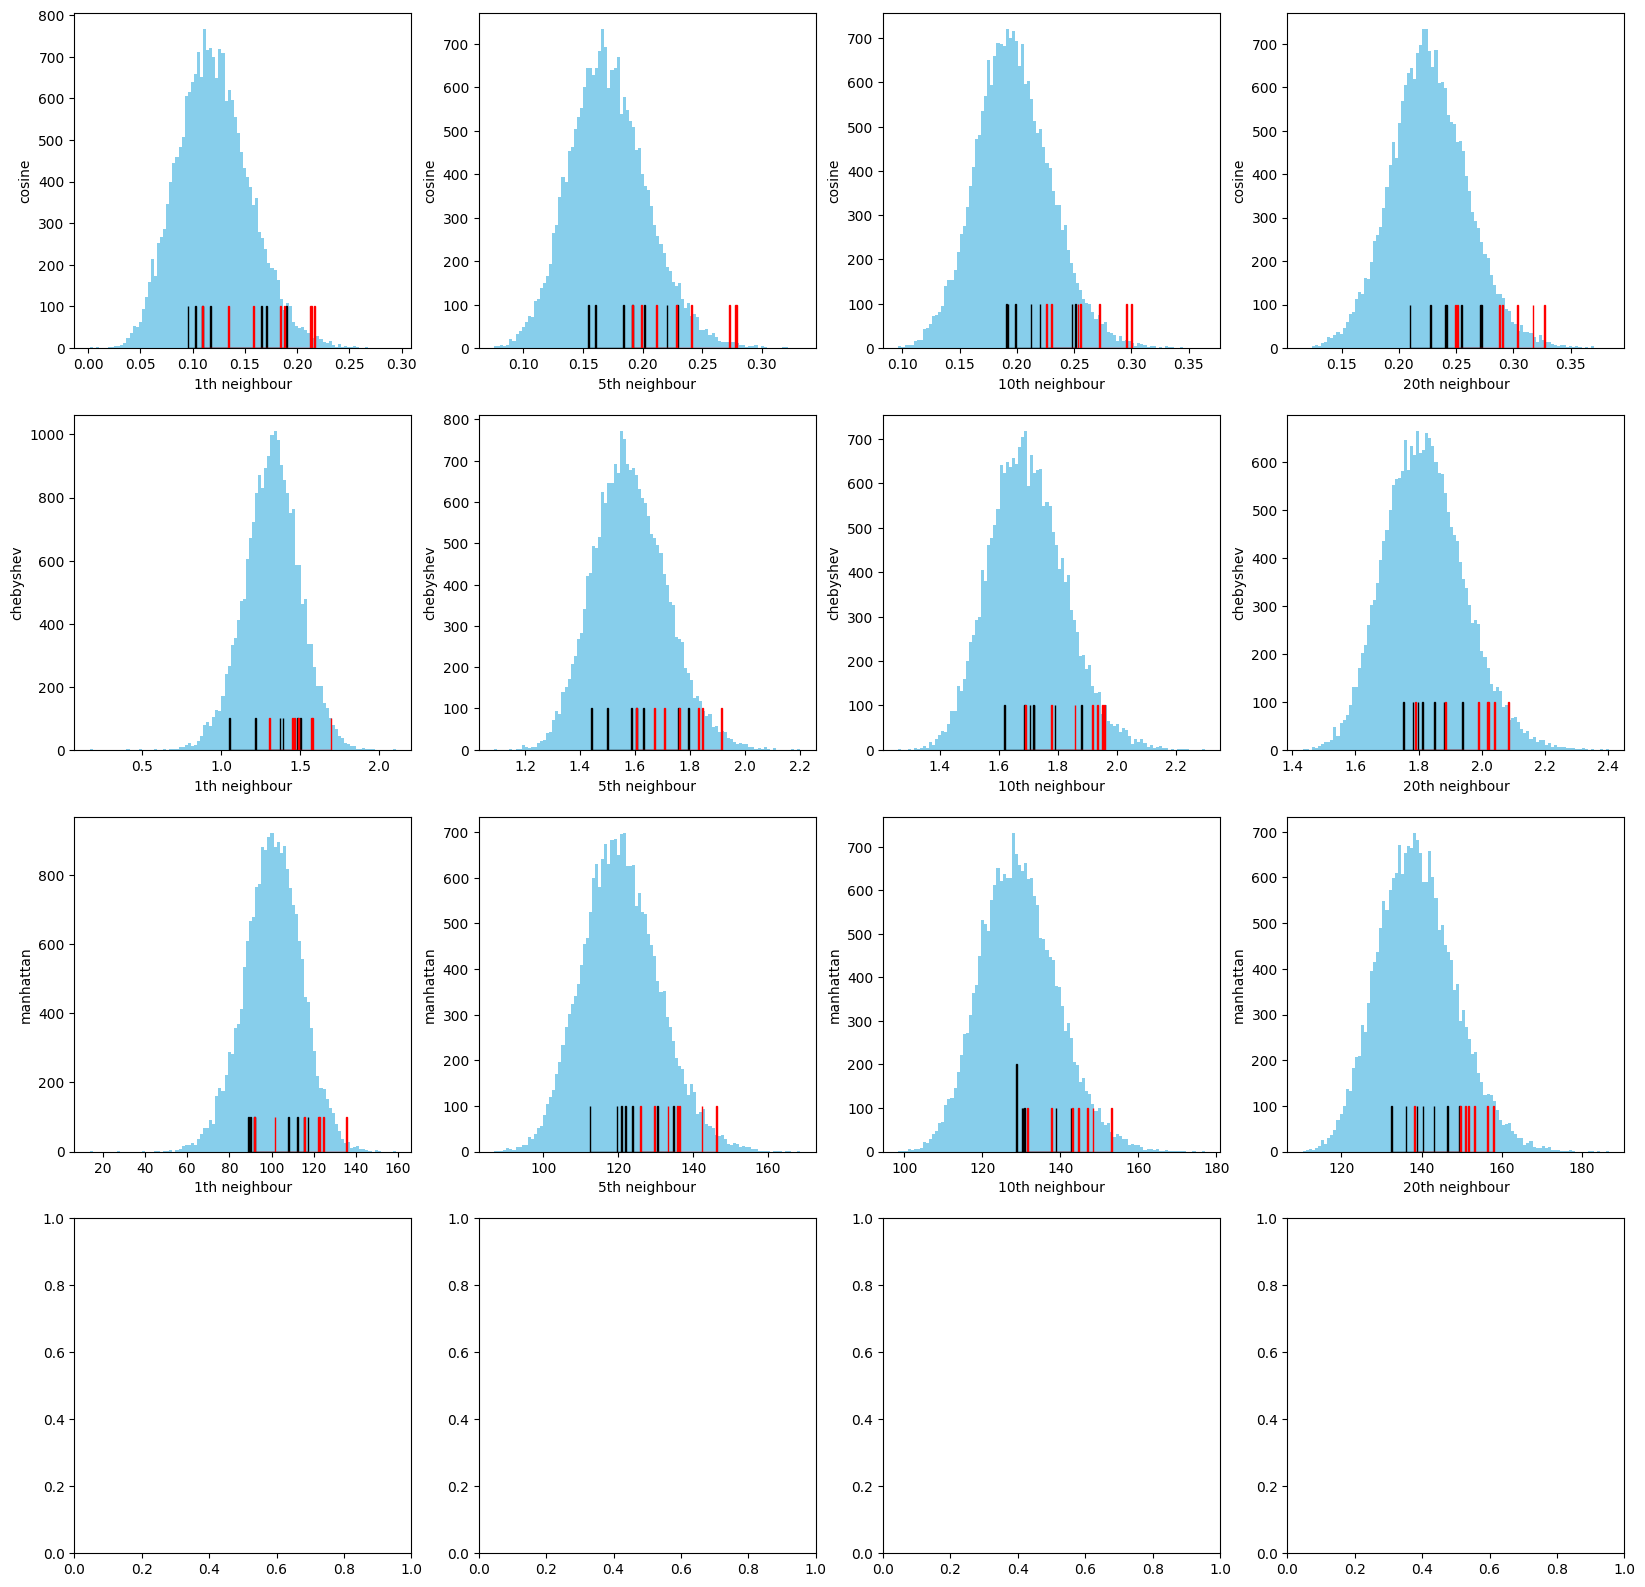

In [57]:
## loop on the metrics and the neighbours to plot
nb_neighbours = [1,5,10,20]
fig, axs = plt.subplots(nrows=len(metrics), ncols=len(nb_neighbours), figsize=(20,20))
bins=100

dict_furthest_subs = {metric: {} for metric in metrics}

for i, metric in enumerate(metrics):
    df_sorted_dists = dict_distances[metric]
    for j, k in enumerate(nb_neighbours):
        distance_to_kth_neighbour = df_sorted_dists[k]
        furthest_subs = distance_to_kth_neighbour.sort_values()[-12:].index.tolist()
        dict_furthest_subs[metric][str(k)]=furthest_subs
        ax = axs[i,j]
        ax.hist(distance_to_kth_neighbour[:21045], label='UkBioBank', color='skyblue', bins=bins)
        ax.hist(np.stack([distance_to_kth_neighbour[21045:21052] for i in range(100)]).flatten(), label='CCD controls', color='black', ec='black', bins=bins)
        ax.hist(np.stack([distance_to_kth_neighbour[21052:21059] for i in range(100)]).flatten(), label='CCD anomaly', color='red', ec='red', bins=bins)
        ax.set_ylabel(metric)
        ax.set_xlabel(f'{k}th neighbour')
plt.legend()
plt.tight_layout()
plt.show()

In [64]:
dict_furthest_subs['cosine']['1']

['sub-4830095',
 'sub-3174845',
 'sub-1313297',
 'sub-1347557',
 'sub-3552064',
 'sub-3309423',
 'sub-2078993',
 'sub-3945959',
 'sub-1024948',
 'sub-3343267',
 'sub-1566664',
 'sub-3999349']

In [65]:
dict_furthest_subs['cosine']['5']

['sub-2711476',
 'sub-3377257',
 'sub-4556181',
 'sub-3920439',
 'sub-5751320',
 'sub-3552064',
 'sub-3172477',
 'sub-1566664',
 'sub-4830095',
 'sub-3429791',
 'sub-3174845',
 'sub-3999349']

# PCA to 20 dimensions ?

In [55]:
pca = PCA(n_components=5)
pca.fit(scl_bdd_ukb)
reduced_all_subs_embs = pd.DataFrame(pca.transform(all_subs_embs.values),
                                     index=all_subs_embs.index)

# build a dict of distances
dict_reduced_distances = {}
metrics = ['cosine', 'chebyshev', 'manhattan', 'euclidean']
for metric in metrics:
    pairwise_dists = pairwise_distances(reduced_all_subs_embs, metric=metric)
    sorted_dists = np.sort(pairwise_dists)
    df_sorted_dists = pd.DataFrame(data=sorted_dists, index=all_subs_embs.index, columns = [k for k in range(len(sorted_dists))])
    dict_reduced_distances[metric]=df_sorted_dists

/neurospin/dico/jlaval/Runs_jl277509/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


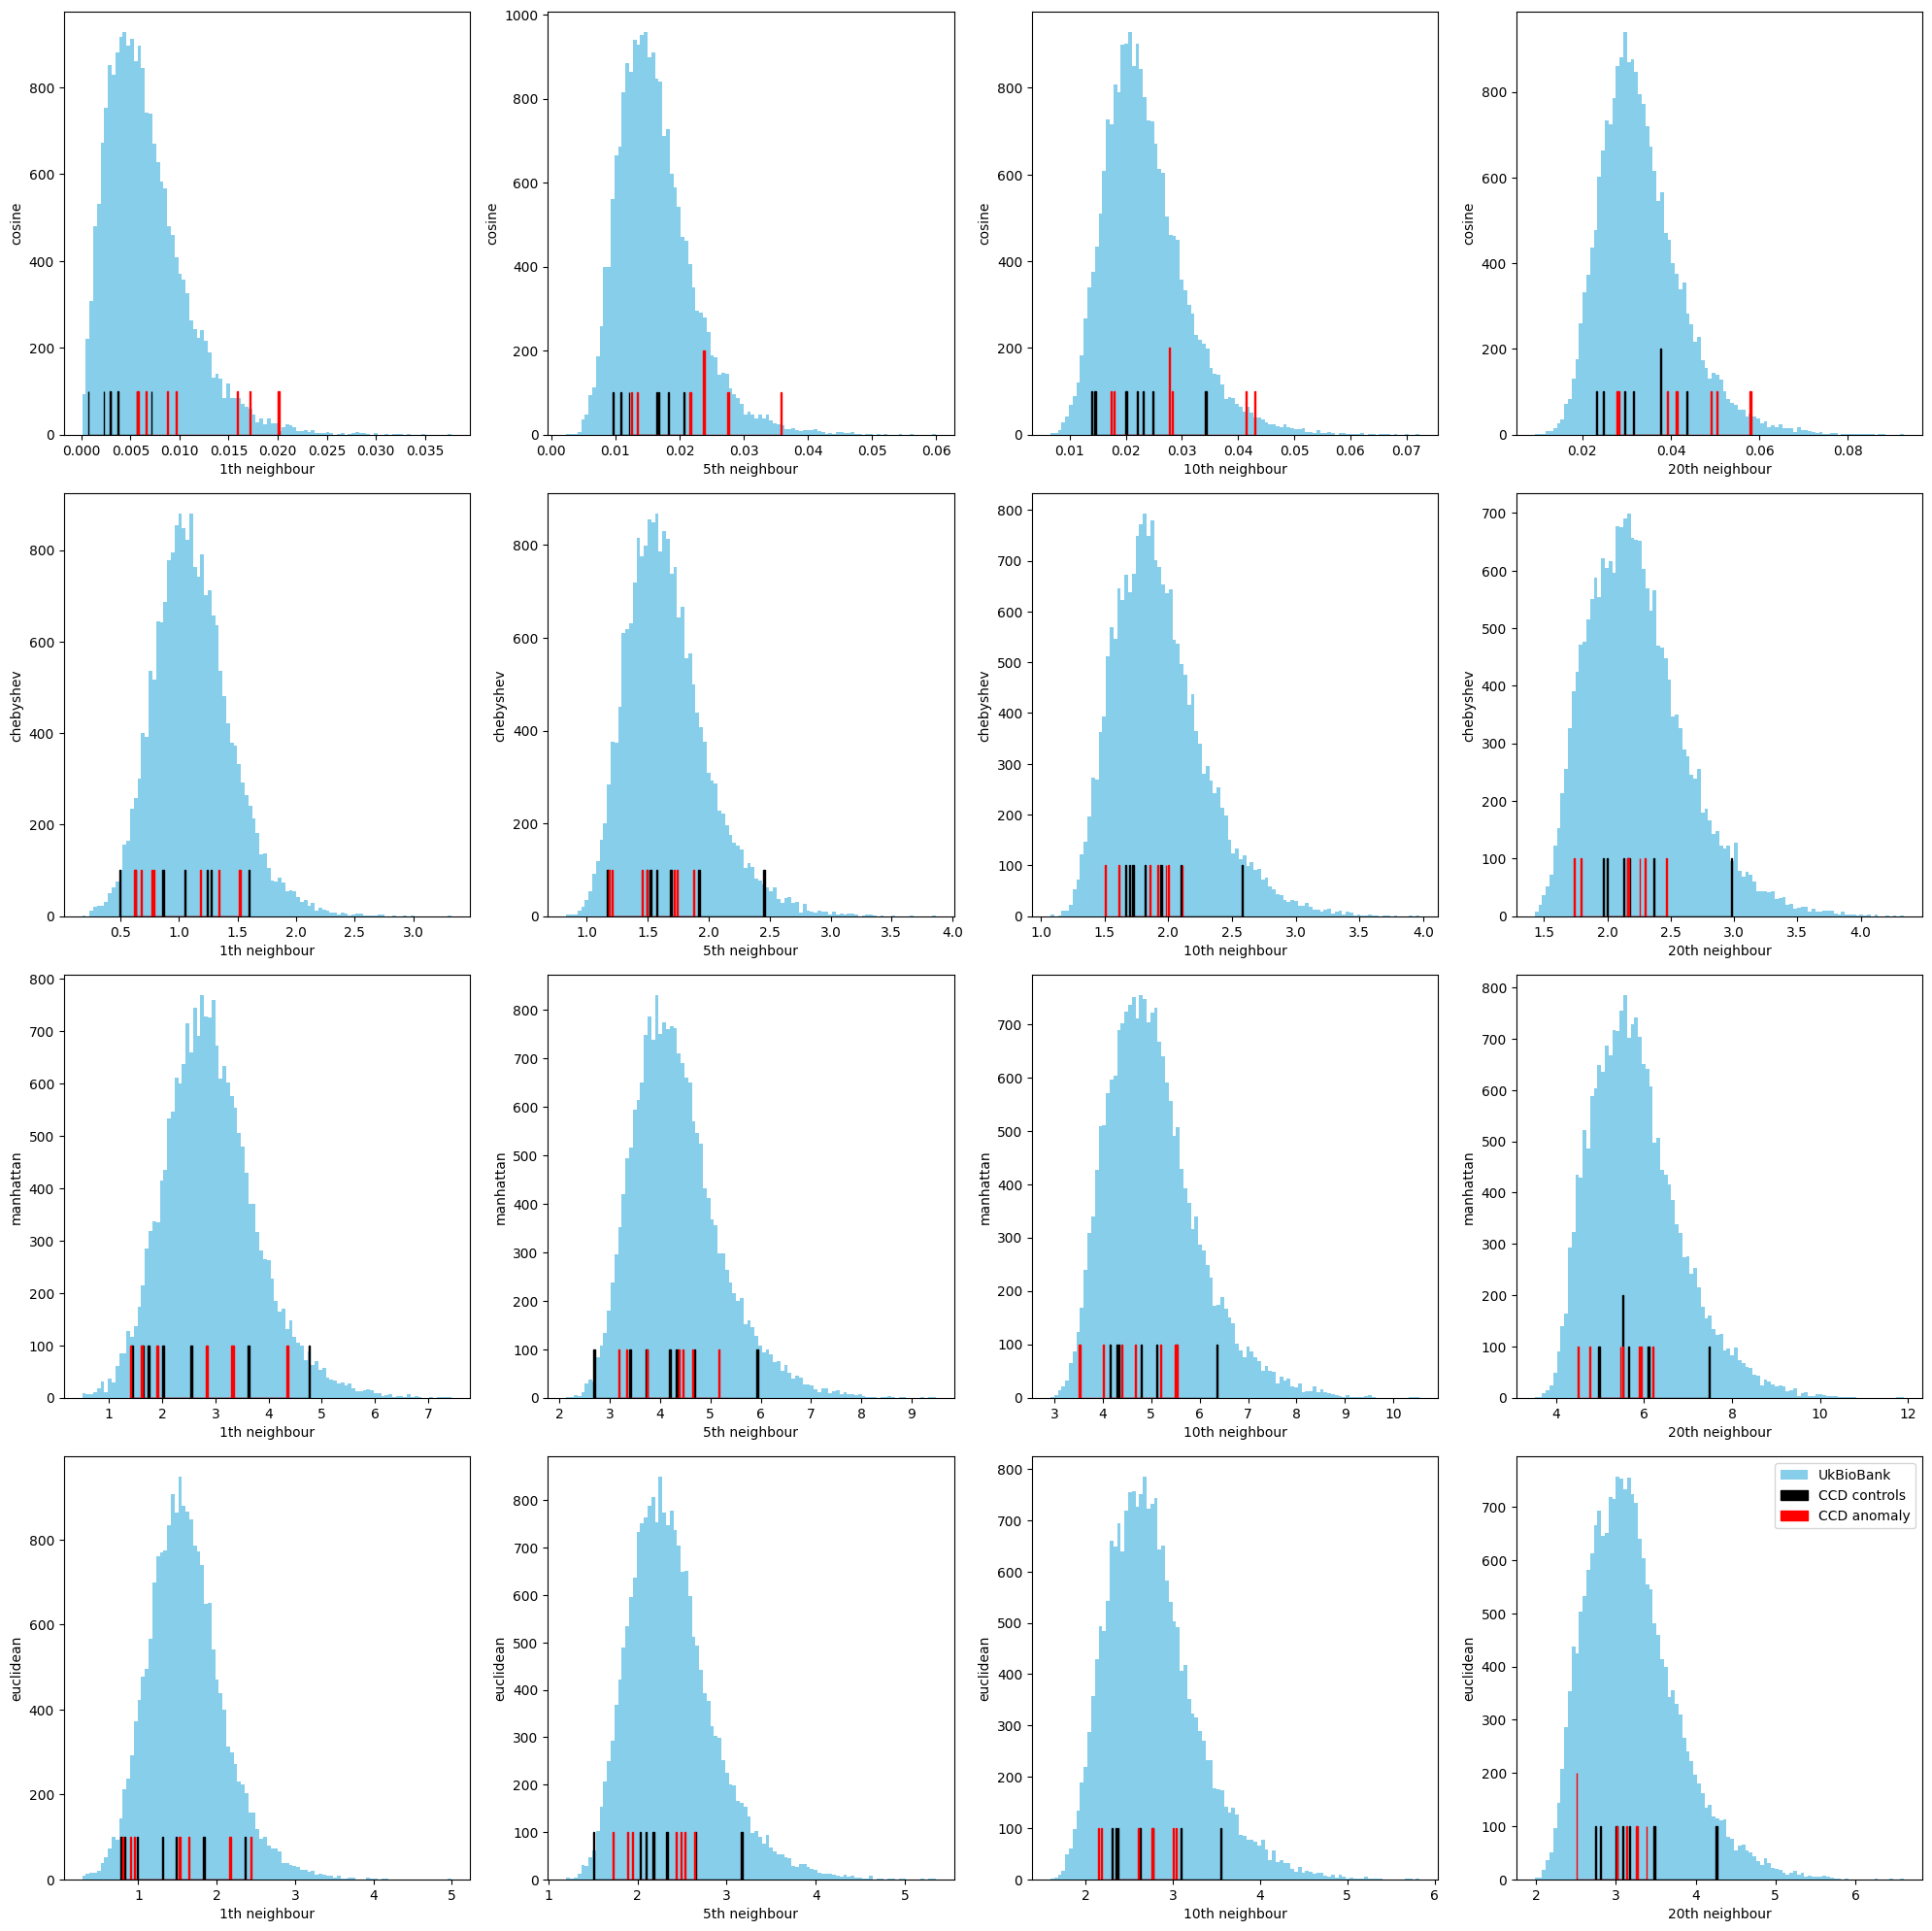

In [56]:
## loop on the metrics and the neighbours to plot
nb_neighbours = [1,5,10,20]
fig, axs = plt.subplots(nrows=len(metrics), ncols=len(nb_neighbours), figsize=(20,20))
bins=100

dict_furthest_subs = {metric: {} for metric in metrics}

for i, metric in enumerate(metrics):
    df_sorted_dists = dict_reduced_distances[metric]
    for j, k in enumerate(nb_neighbours):
        distance_to_kth_neighbour = df_sorted_dists[k]
        furthest_subs = distance_to_kth_neighbour.sort_values()[-12:].index.tolist()
        dict_furthest_subs[metric][str(k)]=furthest_subs
        ax = axs[i,j]
        ax.hist(distance_to_kth_neighbour[:21045], label='UkBioBank', color='skyblue', bins=bins)
        ax.hist(np.stack([distance_to_kth_neighbour[21045:21052] for i in range(100)]).flatten(), label='CCD controls', color='black', ec='black', bins=bins)
        ax.hist(np.stack([distance_to_kth_neighbour[21052:21059] for i in range(100)]).flatten(), label='CCD anomaly', color='red', ec='red', bins=bins)
        ax.set_ylabel(metric)
        ax.set_xlabel(f'{k}th neighbour')
plt.legend()
plt.tight_layout()
plt.show()

# Measure similarity with neighbours in the pixel space

In [3]:
model = '/volatile/jl277509/Runs/02_STS_babies/Program/Output/PCS_FINAL_MODEL/19-12-25_2/' # right
#model = '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/CINGULATE_left/2024-07-15/17-13-32_0' ## left

embeddings_CCD = pd.read_csv(os.path.join(model, "CCD_random_embeddings/full_embeddings.csv"), index_col=0)
embeddings_UKB = pd.read_csv(os.path.join(model, "UKB_random_embeddings/full_embeddings.csv"), index_col=0)
embeddings_hcp = pd.read_csv(os.path.join(model, "hcp_random_embeddings/full_embeddings.csv"), index_col=0)
embeddings_hcp = embeddings_hcp[~embeddings_hcp.index.duplicated(keep='first')]

In [4]:
CCD_labels = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/CCD/ccd_labels.csv')
CCD_labels = CCD_labels.set_index('Subject')
CCD_labels.index.name='ID'

In [5]:
# load the skeletons
skels_UKB = np.load('/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/crops/2mm/CINGULATE./mask/Rskeleton.npy')
UKB_subjects = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/crops/2mm/CINGULATE./mask/Rskeleton_subject.csv')
skels_CCD = np.load('/neurospin/dico/data/deep_folding/current/datasets/CCD/crops/2mm/CINGULATE./mask/Rskeleton.npy')
CCD_subjects = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/CCD/crops/2mm/CINGULATE./mask/Rskeleton_subject.csv')
skels_hcp = np.load('/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/2mm/CINGULATE./mask/Rskeleton.npy')
hcp_subjects = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/2mm/CINGULATE./mask/Rskeleton_subject.csv')

In [6]:
l_subs = hcp_subjects['Subject']
l_subs = [str(elem) for elem in l_subs]
hcp_subjects['Subject'] = l_subs

In [7]:
# CONCATENATE : NO NEED TO REORDER !!
# WHEN LISTING THE NEIGHBOURS, TAKE THE RIGHT SKELETON DEPENDING ON SUBJECTS.CSV
full_skeletons = np.vstack((skels_UKB, skels_hcp, skels_CCD))
full_subjects = pd.concat((UKB_subjects, hcp_subjects, CCD_subjects))
full_subjects.reset_index(inplace=True, drop=False)

In [8]:
# define average skel to get z-score per pixel
average_skel = np.mean(full_skeletons!=0, axis=0)

In [9]:
#full_skeletons_normalized = np.divide((full_skeletons!=0).astype(int), average_skel)
#full_skeletons_normalized = np.nan_to_num(full_skeletons_normalized)
#full_skeletons_normalized = np.multiply((full_skeletons!=0).astype(int), average_skel)
full_skeletons_normalized = (full_skeletons!=0).astype(int)

In [10]:
emb = embeddings_CCD.merge(CCD_labels, left_index=True, right_index=True)
embeddings_CCD_controls = (emb.loc[emb['CCD']==0]).drop('CCD', axis=1)
embeddings_CCD_anomaly = (emb.loc[emb['CCD']==1]).drop('CCD', axis=1)

In [11]:
scaler = StandardScaler()
scaler.fit(embeddings_UKB)

scl_bdd_ccd_control = scaler.transform(embeddings_CCD_controls)
scl_bdd_ccd_anomaly = scaler.transform(embeddings_CCD_anomaly)
scl_bdd_ukb = scaler.transform(embeddings_UKB)
scl_bdd_hcp = scaler.transform(embeddings_hcp)

In [12]:
# gather all embeddings
subs_hcp = [str(elem) for elem in embeddings_hcp.index.tolist()]
subs = embeddings_UKB.index.tolist() + subs_hcp + embeddings_CCD_controls.index.tolist() + embeddings_CCD_anomaly.index.tolist()
embs = np.vstack((scl_bdd_ukb, scl_bdd_hcp, scl_bdd_ccd_control, scl_bdd_ccd_anomaly))
df_embeddings = pd.DataFrame(embs, index=subs)

In [13]:
# compute pairwise distances
pairwise_dists = pairwise_distances(df_embeddings, metric='cosine')
pairwise_dists = pd.DataFrame(pairwise_dists, index=subs, columns=subs)

In [127]:
# for one subject, find the 30 nearest neighbours
k=30
list_subject = pairwise_dists.index.tolist()

list_ratio = []
list_ratio_ponderated = []

for subject in tqdm(list_subject):
    subject = str(subject)
    skel = full_skeletons_normalized[full_subjects.loc[full_subjects['Subject']==subject].index.tolist()[0]]
    neighbours = pairwise_dists.loc[subject].sort_values().index.tolist()[:k]
    list_idx = full_subjects.loc[full_subjects['Subject'].isin(neighbours)].index.tolist()[1:]
    neigh_skels = full_skeletons_normalized[list_idx]
    mask = np.sum(neigh_skels, axis=0)
    intersection = mask.copy()
    intersection[skel==0]=0
    inter = np.sum(intersection)
    total = np.sum(mask)
    ratio = inter / total
    list_ratio.append(ratio)
    list_ratio_ponderated.append(ratio / np.sum(skel!=0))

100%|██████████| 22172/22172 [02:25<00:00, 151.91it/s]


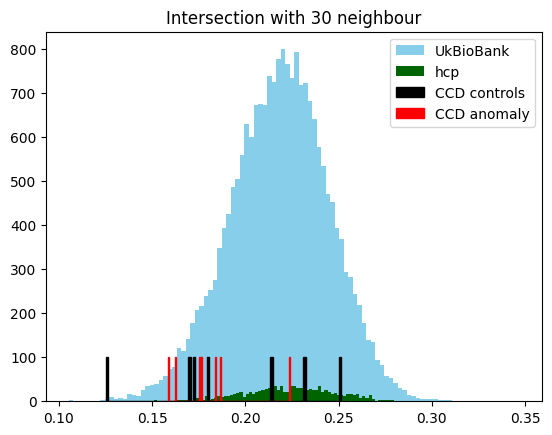

In [128]:
fig, ax = plt.subplots()
bins=100
ax.hist(list_ratio[:21045], label='UkBioBank', color='skyblue', bins=bins)
ax.hist(list_ratio[21045:-14], label='hcp', color='darkgreen', bins=bins)
ax.hist(np.stack([list_ratio[-14:-7] for i in range(100)]).flatten(), label='CCD controls', color='black', ec='black', bins=bins)
ax.hist(np.stack([list_ratio[-7:] for i in range(100)]).flatten(), label='CCD anomaly', color='red', ec='red', bins=bins)
plt.title(f'Intersection with {k} neighbour')
plt.legend()
plt.show()

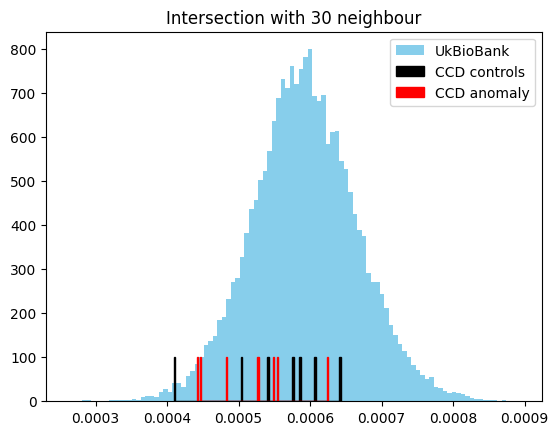

In [129]:
fig, ax = plt.subplots()
bins=100
ax.hist(list_ratio_ponderated[:21045], label='UkBioBank', color='skyblue', bins=bins)
ax.hist(np.stack([list_ratio_ponderated[21045:21052] for i in range(100)]).flatten(), label='CCD controls', color='black', ec='black', bins=bins)
ax.hist(np.stack([list_ratio_ponderated[21052:21059] for i in range(100)]).flatten(), label='CCD anomaly', color='red', ec='red', bins=bins)
plt.title(f'Intersection with {k} neighbour')
plt.legend()
plt.show()

In [130]:
df_ratio = pd.DataFrame(list_ratio, index=pairwise_dists.index.tolist())
sorted_df_ratio = df_ratio.sort_values(0)

In [131]:
print(sorted_df_ratio.index.tolist()[-15:])

['sub-2739822', 'sub-4706505', 'sub-3974161', 'sub-1822141', 'sub-2486372', 'sub-1873747', 'sub-1476604', 'sub-3538950', 'sub-3105839', 'sub-1808665', 'sub-3284441', 'sub-1485567', 'sub-4602321', 'sub-3897958', 'sub-4989927']


In [132]:
df_ratio_prop = pd.DataFrame(list_ratio_ponderated, index=pairwise_dists.index.tolist())
sorted_df_ratio_prop = df_ratio_prop.sort_values(0)

In [133]:
print(sorted_df_ratio_prop.index.tolist()[:15])

['sub-1340648', 'sub-1903469', 'sub-1052236', 'sub-4389685', 'sub-4989927', 'sub-1005290', 'gd070065', 'mm080047', 'pz080261', 'sub-4107177', 'sub-2501331', 'sub-3848556', 'sub-1453113', 'sub-1002188', 'sub-4024647']


In [134]:
size = np.sum(full_skeletons!=0, axis=(1,2,3,4)) ## size
df_size = pd.DataFrame(size, index=full_subjects['Subject'].tolist(), columns=['size'])

In [135]:
df_ratio.columns=['metric']
df_merged = pd.merge(df_ratio, df_size, left_index=True, right_index=True)
df_merged

,metric,size
sub-1000021,0.202227,377
sub-1000458,0.201888,365
sub-1000575,0.196028,397
sub-1000606,0.198675,365
sub-1000963,0.141650,326
...,...,...
gd070065,0.175530,590
lc110410,0.223780,598
np090301,0.186723,458
pa080037,0.183881,524


In [136]:
df_merged.corr()

,metric,size
metric,1.000000,0.490832
size,0.490832,1.000000


In [137]:
import statsmodels.api as sm

# Pre-residualize and transform data
X = df_merged['size']
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = df_merged['metric']
model = sm.OLS(y, X, missing='drop').fit()
# Get residuals
residuals = model.resid

In [138]:
residuals

sub-1000021   -0.017273
sub-1000458   -0.014329
sub-1000575   -0.028944
sub-1000606   -0.017542
sub-1000963   -0.063897
                 ...   
gd070065      -0.102245
lc110410      -0.056184
np090301      -0.054938
pa080037      -0.075837
pz080261      -0.094755
Length: 22172, dtype: float64

In [139]:
residuals.sort_values()[:25].index.tolist()

['sub-1340648',
 'sub-1903469',
 'sub-1052236',
 'sub-4389685',
 'sub-1005290',
 'mm080047',
 'gd070065',
 'sub-2501331',
 'sub-4989927',
 'sub-4107177',
 'sub-1002188',
 'pz080261',
 'sub-4024647',
 'sub-1453113',
 'sub-1091648',
 'sub-1945921',
 'sub-5980436',
 'sub-5838136',
 'sub-4772993',
 'sub-1032975',
 'sub-3191509',
 'sub-2889071',
 'sub-1113217',
 'sub-5782466',
 'sub-3309423']

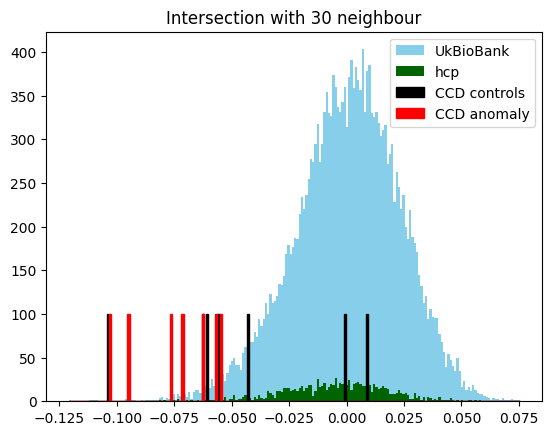

In [164]:
fig, ax = plt.subplots()
bins=np.histogram(residuals, bins=200)[1] #get the bin edges
ax.hist(residuals[:21045], label='UkBioBank', color='skyblue', bins=bins)
ax.hist(residuals[21045:-14], label='hcp', color='darkgreen', bins=bins)
ax.hist(np.stack([residuals[-14:-7] for i in range(100)]).flatten(), label='CCD controls', color='black', ec='black', bins=bins)
ax.hist(np.stack([residuals[-7:] for i in range(100)]).flatten(), label='CCD anomaly', color='red', ec='red', bins=bins)
plt.title(f'Intersection with {k} neighbour')
plt.legend()
plt.show()

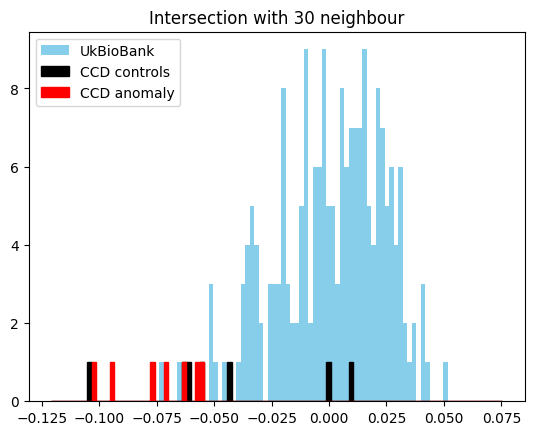

In [166]:
# sample 200 UKB subjects
fig, ax = plt.subplots()
bins=np.histogram(residuals, bins=20)[1] #get the bin edges
ax.hist(residuals[:21045].sample(200), label='UkBioBank', color='skyblue', bins=bins)
ax.hist(np.stack([residuals[-14:-7] for i in range(1)]).flatten(), label='CCD controls', color='black', ec='black', bins=bins)
ax.hist(np.stack([residuals[-7:] for i in range(1)]).flatten(), label='CCD anomaly', color='red', ec='red', bins=bins)
plt.title(f'Intersection with {k} neighbour')
plt.legend()
plt.show()

In [153]:
residuals[-7:]

ca090293   -0.062638
cr070055   -0.071088
gd070065   -0.102245
lc110410   -0.056184
np090301   -0.054938
pa080037   -0.075837
pz080261   -0.094755
dtype: float64

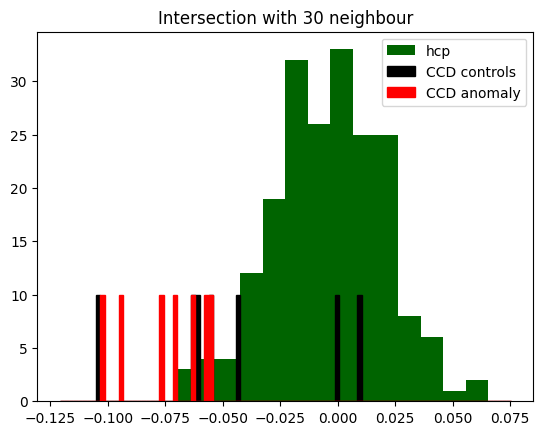

In [188]:
# sample 200 hcp subjects
fig, ax = plt.subplots()
bins=np.histogram(residuals, bins=20)[1] #get the bin edges
bins_=np.histogram(residuals, bins=20*5)[1] #get the bin edges ## UNLUCKY: RED AND BLACK FELL EXACTLY ON THE SAME SPOT ...
ax.hist(residuals[21045:-14].sample(200), label='hcp', color='darkgreen', bins=bins)
ax.hist(np.stack([residuals[-14:-7] for i in range(10)]).flatten(), label='CCD controls', color='black', ec='black', bins=bins_)
ax.hist(np.stack([residuals[-7:] for i in range(10)]).flatten(), label='CCD anomaly', color='red', ec='red', bins=bins_)
plt.title(f'Intersection with {k} neighbour')
plt.legend()
plt.show()

In [149]:
residuals.loc[residuals.index.isin(embeddings_CCD_anomaly.index.tolist())].sort_values()

gd070065   -0.102245
pz080261   -0.094755
pa080037   -0.075837
cr070055   -0.071088
ca090293   -0.062638
lc110410   -0.056184
np090301   -0.054938
dtype: float64

In [150]:
residuals.loc[residuals.index.isin(embeddings_CCD_anomaly.index.tolist())].sort_values().index.tolist()

['gd070065',
 'pz080261',
 'pa080037',
 'cr070055',
 'ca090293',
 'lc110410',
 'np090301']

In [148]:
residuals.loc[residuals.index.isin(embeddings_CCD_controls.index.tolist())].sort_values().index.tolist()

['mm080047',
 'fb070174',
 'cd100556',
 'md110095',
 'bt080019',
 'vp100400',
 'ag080048']

In [189]:
pairwise_dists['gd070065'].sort_values()

gd070065       0.000000
139839         0.201993
sub-5907151    0.229656
sub-4059839    0.230545
sub-1228669    0.237040
                 ...   
sub-4926158    1.738564
sub-1113022    1.745061
sub-1096759    1.745614
sub-5598602    1.749122
sub-4461088    1.761541
Name: gd070065, Length: 22172, dtype: float64

In [210]:
pairwise_dists['sub-5782466'].sort_values().index.tolist()[1:17]

['sub-2223750',
 '360030',
 'sub-4773054',
 'sub-4192477',
 'sub-5714152',
 'sub-1018758',
 'sub-4883692',
 'sub-4997656',
 'sub-4487108',
 'sub-4391070',
 'sub-5079960',
 'sub-4674301',
 'sub-4094345',
 'sub-3890336',
 'sub-2039056',
 'sub-1356295']

In [209]:
## ukb sub with the most resembling neighbours
residuals[:21045].sort_values().index.tolist()[20]

'sub-5782466'

## TODO: comparer à un voisinage aléatoire pour voir s'ils tombent vraiment aléatoirement dans la latente